In [1]:
import numpy as np
import matplotlib.pyplot as plt
import examples
import okada
from patch_geometry import ver2patchconnect
%matplotlib  widget

In [2]:
# Set of fault parameters for ~LS fault, Sierra El-Mayor 2010 EQ. 
# Which paper has most of these? 

# Gonzalez-Ortega et al., 2014
# Right lateral strike-slip, 120 km-long rupture (surface rupture? or this is length of fault slip?)
# seismogenic zone extending to a depth of ~10 km: Castro et al., 2011
# 

xcen = 0
ycen = 0
U = -1.0 # using 1m right-lateral slip for now
#U = -4.0 # this is maximum slip from EQ- negative makes sure it's right-lateral 
d = 2500 # shallow d=depth to CENTROID of fault surface. Not the top surface.
#d=5000
#d = 7500 # a little deeper
nu = 0.27 # using the default value here
delta = 71 # using fault segment 3 from Fialko et al., 2010
#strike = 308 # using fault segment 3, clockwise from north 
strike=0 # making it north-south trending for nice easy horizontal transect 
#length = 13480 # using fault segment 3 
length = 100000
#width = 10000 # up to depth 10 km 
width = 5000
fault_type = 1 # strike-slip 

In [3]:
# points along a transect that we want to compute slip for. This skips the area right around the fault itself.
x_vals_left = np.arange(-100000,-2999,1000)
x_vals_right = np.arange(3000,100001,1000)
x_vals = np.hstack((x_vals_left,x_vals_right))
print(np.shape(x_vals))

(196,)


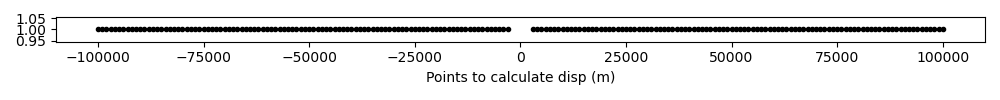

In [4]:
plt.figure(figsize=(10,1),tight_layout=True)
plt.plot(x_vals,np.ones(np.shape(x_vals)),'k.')
plt.xlabel('Points to calculate disp (m)')
plt.show()
#print(x_vals)

In [5]:
# make a transect across x values of Okada slip outputs 
#x_vals = np.arange(-100000,100000,1000)

dx = len(x_vals)

# initialize array for north disps across the x_vals
transect_north = np.ndarray(shape=(dx,),dtype='float')

for x in range(dx):
    x_temp = x_vals[x]
    ue,un,uz = okada.forward(x=x_temp, y=0.0, xcen=xcen, ycen=ycen, \
                         depth=d, length=length, width=width, \
                         slip=U, opening=0.0,  \
                         strike=strike, dip=delta, rake=0.0, \
                         nu=nu)
    # now put the east,north,up displacements into their respective transect
    # starting with just north disps
    transect_north[x] = un

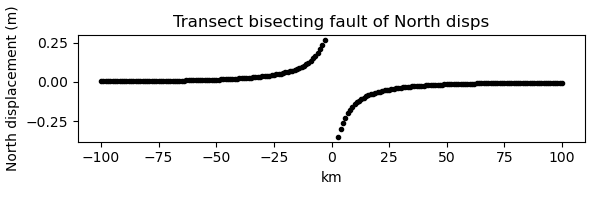

In [6]:
plt.figure(figsize=(6,2),tight_layout=True)
plt.plot(x_vals/1000,transect_north,'k.')
plt.xlabel('km')
plt.ylabel('North displacement (m)')
plt.title('Transect bisecting fault of North disps')
plt.show()

Doing the fitting in one dimension, solving for best-fit x-fault location. 

In [7]:
# This is an example of solving for fault slip with the above info 

print('Array sizes: ')
# Making sure it's the right size array. 
G = transect_north.reshape((dx,1))
print('G: \t\t'+str(np.shape(G)))

# m is the amount of slip (in meters) we want on the fault 
m = [1.0]
print('input m: \t'+str(np.shape(m)))

# dat is the forward-modelled data that we use with G to get m. 
dat = np.matmul(G,m)
print('d: \t\t'+str(np.shape(dat)))

# This is the inverse thing that operates on data to get m
Gg = np.matmul(np.linalg.inv(np.matmul(G.T,G)),G.T)
print('Gg: \t\t'+str(np.shape(Gg)))

# solve for the amount of slip on the fault with Gg and the data 
m1 = np.matmul(Gg,dat)
print('solved-for m: \t'+str(np.shape(m1)))

print('\nModel input and output: ')
# make sure that the solved-for fault slip is the same as the forward one.
print('input m: \t'+str(m))
print('solved-for m: \t'+str(m1))

Array sizes: 
G: 		(196, 1)
input m: 	(1,)
d: 		(196,)
Gg: 		(1, 196)
solved-for m: 	(1,)

Model input and output: 
input m: 	[1.0]
solved-for m: 	[1.]


In [8]:
# dat is the exact same as transect_north as long as the slip is the same. Confirming that here. 
print(np.all(transect_north==dat))

True


In [9]:
# Shift the x location of the fault for the new Gg matrix that will invert with the original/"correct" data, calculate misfit and L2 norm.

# loop over different x locations of fault. The "correct" one is 0, so maybe let's loop over -10000 m to 10000 m 
x_fault_locs = np.arange(-10000,10000,1000)
m_vals_solved = np.ndarray((len(x_fault_locs),),dtype='float')
L2_norms = np.ndarray((len(x_fault_locs),),dtype='float')

# dat will be the same for every iteration - calculated in above cell.
# keeping the same m from before (1m slip)

# for each fault x-location iteration, forward model it and compare to "true" data 
for i in range(len(x_fault_locs)):
    # forward model the data, then invert it with the already-made Gg from fault patch 1 
    transect_north_temp = np.ndarray(shape=(dx,),dtype='float')
    # loop over all the x vals to create the transect for a fault at the present x_fault_loc
    for x in range(dx):
        x_temp = x_vals[x]
        ue,un,uz = okada.forward(x=x_temp, y=0.0, xcen=x_fault_locs[i], ycen=ycen, \
                            depth=d, length=length, width=width, \
                            slip=U, opening=0.0,  \
                            strike=strike, dip=delta, rake=0.0, \
                            nu=nu)
        transect_north_temp[x] = un
    # make the temporary G matrix for this fault x location 
    G_temp = transect_north_temp.reshape(dx,1)
    # make a temporary Gg matrix for inverting data
    Gg_temp = np.matmul(np.linalg.inv(np.matmul(G_temp.T,G_temp)),G_temp.T)
    # Then use the temporary Gg (from current configuration of data) to invert this fault slip configuration with 'correct' data
    m_temp = np.matmul(Gg_temp,dat)
    # put it into the array for the 'solved-for' model values 
    m_vals_solved[i] = m_temp[0]
    # re-predict the G/disp transect with the m_vals_solved value 
    dat_predicted = np.matmul(G_temp,m_temp)
    # take the norm of the residuals (L2 norm) btw "correct" data (dat) and re-predicted data (dat_predicted)
    L2_norms[i] = np.linalg.norm(dat-dat_predicted)

    # Notes from meeting with Rowena: 
    # Use the 'wrong' Gg with the right data 
    # new forward model with the wrong Gg and wrong model 
    # then claculate the norm of the residual 
    # show the m, in real case you don't know that 
    # 
    # try 10 in each dimension, find best x,z for each dip, use her code to find gemoetry/corners of the fault and save it. 
    # color each one by the slip that was solved-for, peak where it fits the data well. 

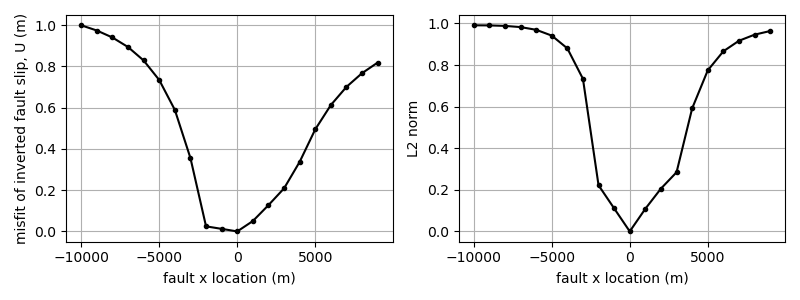

In [10]:
plt.figure(figsize=(8,3),tight_layout=True)
plt.subplot(1,2,1)
plt.plot(x_fault_locs,np.abs(m_vals_solved-np.abs(U)),'k.-')
plt.xlabel('fault x location (m)')
plt.ylabel('misfit of inverted fault slip, U (m)')
plt.grid()
plt.subplot(1,2,2)
plt.plot(x_fault_locs,L2_norms,'k.-')
plt.xlabel('fault x location (m)')
plt.ylabel('L2 norm')
plt.grid()
plt.show()
# these plots are lumpy if the original data only has many more datapoints (spaced closer together), so it fits a little better to the data at those spots. 
# ideally we wouldn't have a smaller grid spacing for fitting than we do the original data, but at least we know why it's a little weird-looking now.

In [11]:
# Now loop over lots of dips, x and z fault locations, and find the modelled slip value and the residual norm (L2 norm) for each combo. 

# dip values to loop over 
dips = np.arange(21,90,5)
print('Number of dips to loop over: '+str(len(dips)))
print(dips)

# x-location values to loop over 
x_fault_locs = np.arange(-3000,17001,1000)
print('\nNumber of x locations to loop over: '+str(len(x_fault_locs)))
print(x_fault_locs)

# depths to loop over 
# start at zero depth BUT leave a Nan in the big 3D array IF the depth is too shallow (above ground, Okada model won't take it)
z_fault_locs = np.arange(0,10001,500)
print('\nNumber of z locations to loop over: '+str(len(z_fault_locs)))
print(z_fault_locs)

# how many loop iterations total in the triple loop?
print('\nNumber of loop iterations total: '+str(len(dips)*len(x_fault_locs)*len(z_fault_locs)))

Number of dips to loop over: 14
[21 26 31 36 41 46 51 56 61 66 71 76 81 86]

Number of x locations to loop over: 21
[-3000 -2000 -1000     0  1000  2000  3000  4000  5000  6000  7000  8000
  9000 10000 11000 12000 13000 14000 15000 16000 17000]

Number of z locations to loop over: 21
[    0   500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500
  6000  6500  7000  7500  8000  8500  9000  9500 10000]

Number of loop iterations total: 6174


In [12]:
# This is a longer version of the code I was testing before I wrote the functions to use instead. 

'''
# make a data cube (3D array) to hold the residual norms (L2 norms) for each combination of dip, z fault location, and x fault location 
L2_norms = np.ndarray((len(dips),len(z_fault_locs),len(x_fault_locs)),dtype='float')
# make a data cube (3D array) to hold the solved-for m/model values (fault slip, U)
m_vals_solved = np.ndarray((len(dips),len(z_fault_locs),len(x_fault_locs)),dtype='float')
# temporary array for holding Okada-modelled north disp values for transect of x values. 
temp_okada_vals = np.ndarray((len(x_vals)),dtype='float')

# loop over dips, x fault locations, and z fault locations, make a transect along x_vals, solve for m, calculate residuals, 
for di in range(len(dips)): # range(len(dips))
    print('dip: '+str(dips[di]))
    
    # for this dip value, need to loop over x-location and depths (z)
    for x in range(len(x_fault_locs)): # range(len(x_fault_locs))
        print('\tx fault loc: '+str(x_fault_locs[x]))
        
        for z in range(len(z_fault_locs)): # range(len(z_fault_locs))
            
            for i in range(len(x_vals)):
                x_temp = x_vals[i]
                # Now run the Okada model with the parameters I'm looping over 
                ue,un,uz = okada.forward(x=x_temp, y=0.0, xcen=x_fault_locs[x], ycen=ycen, \
                                depth=z_fault_locs[z], length=length, width=width, \
                                slip=U, opening=0.0,  \
                                strike=strike, dip=dips[di], rake=0.0, \
                                nu=nu)
                # now put the north displacements into their respective transect
                temp_okada_vals[i] = un
            
            # plt.figure(figsize=(3,3))
            # plt.plot(x_vals,temp_okada_vals,'k.-')
            # plt.show()

            # Now invert for the amount of slip, and calculate misfit to the "true" transect of north disp values and save those values 
            # make the temporary G matrix for this fault x location 
            G_temp = temp_okada_vals.reshape(dx,1)
            # make a temporary Gg matrix for inverting data
            Gg_temp = np.matmul(np.linalg.inv(np.matmul(G_temp.T,G_temp)),G_temp.T)
            # Then use the temporary Gg (from current configuration of data) to invert this fault slip configuration with 'correct' data
            m_temp = np.matmul(Gg_temp,dat)
            # put it into the array for the 'solved-for' model values 
            m_vals_solved[di,z,x] = m_temp[0]
            # re-predict the G/disp transect with the m_vals_solved value 
            dat_predicted = np.matmul(G_temp,m_temp)
            # take the norm of the residuals (L2 norm) btw "correct" data (dat) and re-predicted data (dat_predicted)
            L2_norms[display_pdf,z,x] = np.linalg.norm(dat-dat_predicted)
'''

'\n# make a data cube (3D array) to hold the residual norms (L2 norms) for each combination of dip, z fault location, and x fault location \nL2_norms = np.ndarray((len(dips),len(z_fault_locs),len(x_fault_locs)),dtype=\'float\')\n# make a data cube (3D array) to hold the solved-for m/model values (fault slip, U)\nm_vals_solved = np.ndarray((len(dips),len(z_fault_locs),len(x_fault_locs)),dtype=\'float\')\n# temporary array for holding Okada-modelled north disp values for transect of x values. \ntemp_okada_vals = np.ndarray((len(x_vals)),dtype=\'float\')\n\n# loop over dips, x fault locations, and z fault locations, make a transect along x_vals, solve for m, calculate residuals, \nfor di in range(len(dips)): # range(len(dips))\n    print(\'dip: \'+str(dips[di]))\n    \n    # for this dip value, need to loop over x-location and depths (z)\n    for x in range(len(x_fault_locs)): # range(len(x_fault_locs))\n        print(\'\tx fault loc: \'+str(x_fault_locs[x]))\n        \n        for z in r

In [13]:
'''
# plot all slices of the 3D L2_norms array to see if there are global minima I can see visually 
plt.figure(figsize=(13,6),tight_layout=True)
sbplt = 1
for di in range(len(dips)):
    plt.subplot(4,5,sbplt)
    plt.pcolor(x_fault_locs/1000,z_fault_locs/1000,L2_norms[di],cmap='jet')
    plt.xlabel('x fault loc (km)')
    plt.ylabel('z fault loc (km)')
    plt.title('Dip '+str(dips[di]))
    plt.colorbar(label='L2-norm')
    sbplt = sbplt+1
plt.show()
'''

"\n# plot all slices of the 3D L2_norms array to see if there are global minima I can see visually \nplt.figure(figsize=(13,6),tight_layout=True)\nsbplt = 1\nfor di in range(len(dips)):\n    plt.subplot(4,5,sbplt)\n    plt.pcolor(x_fault_locs/1000,z_fault_locs/1000,L2_norms[di],cmap='jet')\n    plt.xlabel('x fault loc (km)')\n    plt.ylabel('z fault loc (km)')\n    plt.title('Dip '+str(dips[di]))\n    plt.colorbar(label='L2-norm')\n    sbplt = sbplt+1\nplt.show()\n"

In [14]:
'''
# find minimum value in temp_res and x,z,dip values that go along with it 
min_index_flat = np.nanargmin(L2_norms) # this is just one number
# need to translate it into 3D indices
min_coords = np.unravel_index(min_index_flat,np.shape(L2_norms))
dip_index = min_coords[0]
z_index   = min_coords[1]
x_index   = min_coords[2]
# based on min_index, find the ideal values of dip, x fault loc, and z fault loc 
best_dip = dips[dip_index]
best_zloc = z_fault_locs[z_index]
best_xloc = x_fault_locs[x_index]

print('Best-fit dip: \t\t'+str(best_dip))
print('Best-fit z location: \t'+str(best_zloc))
print('Best-fit x location: \t'+str(best_xloc))    
'''   

"\n# find minimum value in temp_res and x,z,dip values that go along with it \nmin_index_flat = np.nanargmin(L2_norms) # this is just one number\n# need to translate it into 3D indices\nmin_coords = np.unravel_index(min_index_flat,np.shape(L2_norms))\ndip_index = min_coords[0]\nz_index   = min_coords[1]\nx_index   = min_coords[2]\n# based on min_index, find the ideal values of dip, x fault loc, and z fault loc \nbest_dip = dips[dip_index]\nbest_zloc = z_fault_locs[z_index]\nbest_xloc = x_fault_locs[x_index]\n\nprint('Best-fit dip: \t\t'+str(best_dip))\nprint('Best-fit z location: \t'+str(best_zloc))\nprint('Best-fit x location: \t'+str(best_xloc))    \n"

In [15]:
'''
# Note from meeting with Rowena: 
# now I have my dadat cube, transect thorugh in x dimendion is zero, looking at all dips at all depths 
# will look like a big bullseye  
plt.figure(figsize=(3,2.5))
plt.pcolor(z_fault_locs,dips,L2_norms[:,:,10],cmap='jet')
plt.colorbar(label='L2 norm')
plt.title('X fault location=0')
plt.show()
'''

"\n# Note from meeting with Rowena: \n# now I have my dadat cube, transect thorugh in x dimendion is zero, looking at all dips at all depths \n# will look like a big bullseye  \nplt.figure(figsize=(3,2.5))\nplt.pcolor(z_fault_locs,dips,L2_norms[:,:,10],cmap='jet')\nplt.colorbar(label='L2 norm')\nplt.title('X fault location=0')\nplt.show()\n"

In [16]:
# function takes a single value of faultx,faultz,dip
# produces tempres/L2 norm value 
# also outputs the profile it produced with that combo of fault params, and the slip value 
def L2norm_for_fault_config(x_vals, dat, dip, fault_x_loc, fault_z_loc):
    # how many x values do we have to loop over to produce the transect? 
    dx = len(x_vals)
    temp_okada_vals = np.ndarray((dx,),dtype='float')
    # loop over the x_vals to make the transect
    for i in range(dx):
        x_temp = x_vals[i]
        # Now run the Okada model with the parameters I'm looping over 
        ue,un,uz = okada.forward(x=x_temp, y=0.0, xcen=fault_x_loc, ycen=ycen, \
                        depth=fault_z_loc, length=length, width=width, \
                        slip=U, opening=0.0,  \
                        strike=strike, dip=dip, rake=0.0, \
                        nu=nu)
        # now put the north displacements into their respective transect
        temp_okada_vals[i] = un
    # Now invert for the fault slip that fits this profile/transect 
    G_temp = temp_okada_vals.reshape(dx,1)
    Gg_temp = np.matmul(np.linalg.inv(np.matmul(G_temp.T,G_temp)),G_temp.T)
    m_temp = np.matmul(Gg_temp,dat)
    m_solved = m_temp[0]
    # re-predict the G/disp transect with the m_vals_solved value 
    dat_predicted = np.matmul(G_temp,m_temp)
    # take the norm of the residuals (L2 norm) btw "correct" data (dat) and re-predicted data (dat_predicted)
    temp_L2_norm = np.linalg.norm(dat-dat_predicted)
    # return profile itself, the solved-for slip amount, and the L2-norm
    return dat_predicted, m_solved, temp_L2_norm
# then at the end when I have a best combo of values, run it through this again to get the predicted data/synthetic to plot and stuff 


# make a function to find the x fault location, z fault location, and dip of best fit within the L2_norm data cube 
# # make function for finding values that go with minimum L2-norm 
def find_L2_norm_minimum(L2_norms,dips,x_fault_locs,z_fault_locs):
    # find location of minimum value in L2-norm array 
    min_index_flat = np.nanargmin(L2_norms) # this is just one number
    # need to translate it into 3D indices
    min_coords = np.unravel_index(min_index_flat,np.shape(L2_norms))
    dip_index = min_coords[0]
    z_index   = min_coords[1]
    x_index   = min_coords[2]
    # based on min_index, find the ideal values of dip, x fault loc, and z fault loc 
    best_dip = dips[dip_index]
    best_zloc = z_fault_locs[z_index]
    best_xloc = x_fault_locs[x_index]
    # print out those values 
    print('Best-fit dip: \t\t'+str(best_dip))
    print('Best-fit x location: \t'+str(best_xloc))  
    print('Best-fit z location: \t'+str(best_zloc))
    return best_dip, best_xloc, best_zloc 

In [17]:
# make a data cube (3D array) to hold the residual norms (L2 norms) for each combination of dip, z fault location, and x fault location 
L2_norms = np.ndarray((len(dips),len(z_fault_locs),len(x_fault_locs)),dtype='float')*np.nan
# make a data cube (3D array) to hold the solved-for m/model values (fault slip, U)
m_vals_solved = np.ndarray((len(dips),len(z_fault_locs),len(x_fault_locs)),dtype='float')*np.nan

# loop over dips, x fault locations, and z fault locations, make a transect along x_vals, solve for m, calculate residuals, 
for di in range(len(dips)): # range(len(dips))
    print('\ndip: '+str(dips[di]))
    
    # for each dip and width combo (even though width staying the same here), there is a critical depth that it can't be shallower
    # otherwise fault goes up into the air 
    d_crit = width/2 * np.sin(np.deg2rad(dips[di]))
    print('Cannot be shallower than: \t'+str(d_crit))
    print('\tx fault loc: ',end=' ')
    
    # for this dip value, need to loop over x-location and depths (z)
    for x in range(len(x_fault_locs)): # range(len(x_fault_locs))
        print(str(x_fault_locs[x]),end=' ')
        
        for z in range(len(z_fault_locs)): # range(len(z_fault_locs))

            # only do this calculation IF the z_fault_location is a physically-feasible one. 
            if d_crit<z_fault_locs[z]:
                # with this combo of x_fault_loc, z_fault_loc, and dip 
                dat_predicted, m_solved, temp_L2_norm = L2norm_for_fault_config(x_vals, dat, dips[di], x_fault_locs[x], z_fault_locs[z])
                m_vals_solved[di,z,x] = m_solved
                L2_norms[di,z,x]      = temp_L2_norm
            # implied: else, leave the Nan in the array b/c can't calculate that combo of width/dip/fault depth 


dip: 21
Cannot be shallower than: 	895.9198738632507
	x fault loc:  -3000 -2000 -1000 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 
dip: 26
Cannot be shallower than: 	1095.9278669726934
	x fault loc:  -3000 -2000 -1000 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 
dip: 31
Cannot be shallower than: 	1287.5951872751355
	x fault loc:  -3000 -2000 -1000 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 
dip: 36
Cannot be shallower than: 	1469.463130731183
	x fault loc:  -3000 -2000 -1000 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 
dip: 41
Cannot be shallower than: 	1640.1475724762681
	x fault loc:  -3000 -2000 -1000 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 
dip: 46
Cannot be shallower than: 	1798.3495008466277
	x fault loc:  -3000 -2000 -1000

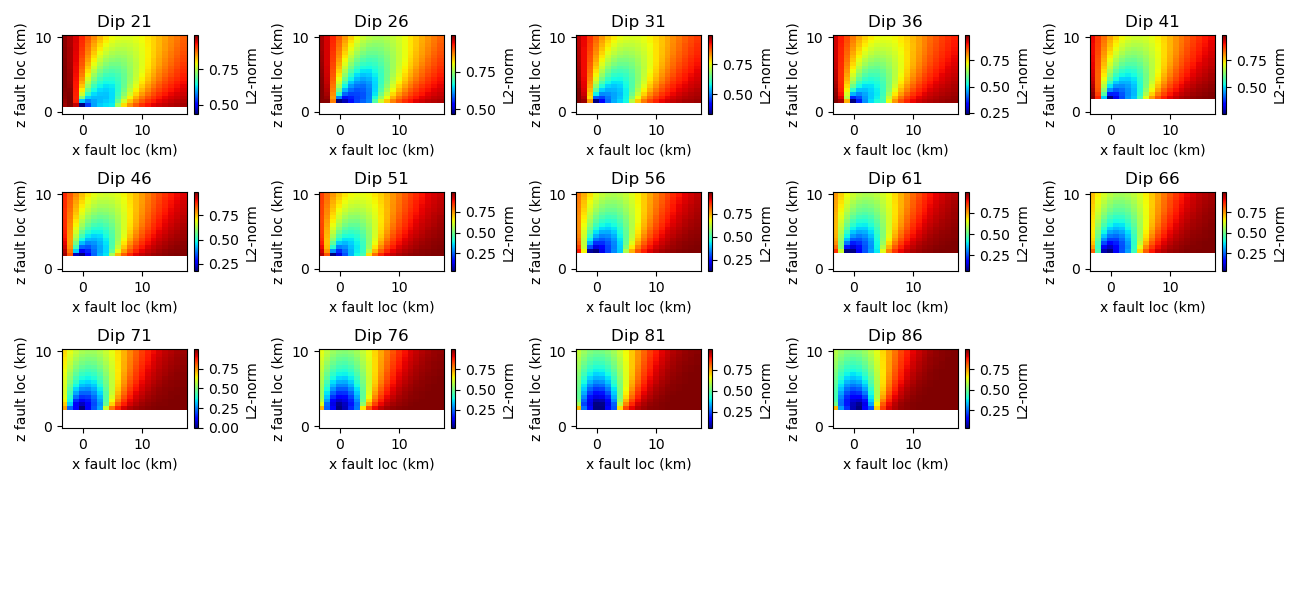

Best-fit dip: 		71
Best-fit x location: 	0
Best-fit z location: 	2500


In [18]:
# plot all slices of the 3D L2_norms array to see if there are global minima I can see visually 
plt.figure(figsize=(13,6),tight_layout=True)
sbplt = 1
for di in range(len(dips)):
    plt.subplot(4,5,sbplt)
    plt.pcolor(x_fault_locs/1000,z_fault_locs/1000,L2_norms[di],cmap='jet')
    plt.xlabel('x fault loc (km)')
    plt.ylabel('z fault loc (km)')
    plt.title('Dip '+str(dips[di]))
    plt.colorbar(label='L2-norm')
    sbplt = sbplt+1
plt.show()

best_dip, best_xloc, best_zloc = find_L2_norm_minimum(L2_norms,dips,x_fault_locs,z_fault_locs)

Yay so these functions work properly! Now what? <br> <br>
Try adding a Laguna Salada-like feature on the left side of the fault. Make it go up by ~10 cm for exaggeration purposes. 

In [19]:
# for i in range(dx):
#     print(i, x_vals[i])

***
***
something is wrong so I am adding nothing for Laguna Salada and figuring out why the "best fit" x location is not zero still. Why did it jump to 9 km?? 
***
***

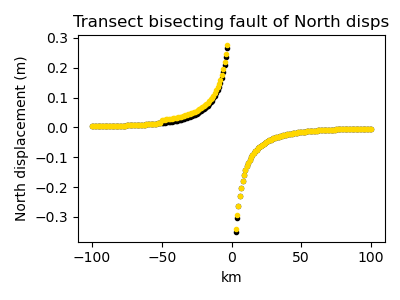

In [20]:
transect_north_LS = transect_north.copy()
# Laguna Salada is ~15 km wide at its wider point.
# But for simplicity, I'm going to add 10 cm slip at -50 km to 0 km 
transect_north_LS[50:100] = transect_north_LS[50:100] + 0.01 

plt.figure(figsize=(4,3),tight_layout=True)
plt.plot(x_vals/1000,transect_north,'k.')
plt.plot(x_vals/1000,transect_north_LS,color='gold',marker='.',linestyle='None')
plt.xlabel('km')
plt.ylabel('North displacement (m)')
plt.title('Transect bisecting fault of North disps')
plt.show()

In [21]:
# Make "true" G and dat
G_2 = transect_north_LS.reshape((dx,1))
m_2 = [1.0]
dat_2 = np.matmul(G_2,m_2)
Gg_2 = np.matmul(np.linalg.inv(np.matmul(G_2.T,G_2)),G_2.T)
m1_2 = np.matmul(Gg_2,dat_2)

print('\nModel input and output: ')
# make sure that the solved-for fault slip is the same as the forward one.
print('input m: \t'+str(m_2))
print('solved-for m: \t'+str(m1_2))


Model input and output: 
input m: 	[1.0]
solved-for m: 	[1.]


In [22]:
# keeping dips, x_fault_locs, and z_fault_locs the same as before

# make a data cube (3D array) to hold the residual norms (L2 norms) for each combination of dip, z fault location, and x fault location 
L2_norms_LS = np.ndarray((len(dips),len(z_fault_locs),len(x_fault_locs)),dtype='float')*np.nan
# make a data cube (3D array) to hold the solved-for m/model values (fault slip, U)
m_vals_solved_LS = np.ndarray((len(dips),len(z_fault_locs),len(x_fault_locs)),dtype='float')*np.nan

# loop over dips, x fault locations, and z fault locations, make a transect along x_vals, solve for m, calculate residuals, 
for di in range(len(dips)): # range(len(dips))
    print('\ndip: '+str(dips[di]))
    
    # for each dip and width combo (even though width staying the same here), there is a critical depth that it can't be shallower
    # otherwise fault goes up into the air 
    d_crit = width/2 * np.sin(np.deg2rad(dips[di]))
    print('Cannot be shallower than: \t'+str(d_crit))
    print('\tx fault loc: ',end=' ')
    
    # for this dip value, need to loop over x-location and depths (z)
    for x in range(len(x_fault_locs)): # range(len(x_fault_locs))
        print(str(x_fault_locs[x]),end=' ')
        
        for z in range(len(z_fault_locs)): # range(len(z_fault_locs))

            # only do this calculation IF the z_fault_location is a physically-feasible one. 
            if d_crit<z_fault_locs[z]:
                # with this combo of x_fault_loc, z_fault_loc, and dip 
                dat_predicted_LS, m_solved_LS, temp_L2_norm_LS = L2norm_for_fault_config(x_vals, dat_2, dips[di], x_fault_locs[x], z_fault_locs[z])
                m_vals_solved_LS[di,z,x] = m_solved_LS
                L2_norms_LS[di,z,x]      = temp_L2_norm_LS
            
            # implied: else, leave the Nan in the array b/c can't calculate that combo of width/dip/fault depth 


dip: 21
Cannot be shallower than: 	895.9198738632507
	x fault loc:  -3000 

/tmp/ipykernel_6935/3303134691.py:4: RuntimeWarning: invalid value encountered in multiply
  L2_norms_LS = np.ndarray((len(dips),len(z_fault_locs),len(x_fault_locs)),dtype='float')*np.nan
/tmp/ipykernel_6935/3303134691.py:6: RuntimeWarning: invalid value encountered in multiply
  m_vals_solved_LS = np.ndarray((len(dips),len(z_fault_locs),len(x_fault_locs)),dtype='float')*np.nan


-2000 -1000 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 
dip: 26
Cannot be shallower than: 	1095.9278669726934
	x fault loc:  -3000 -2000 -1000 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 
dip: 31
Cannot be shallower than: 	1287.5951872751355
	x fault loc:  -3000 -2000 -1000 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 
dip: 36
Cannot be shallower than: 	1469.463130731183
	x fault loc:  -3000 -2000 -1000 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 
dip: 41
Cannot be shallower than: 	1640.1475724762681
	x fault loc:  -3000 -2000 -1000 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 
dip: 46
Cannot be shallower than: 	1798.3495008466277
	x fault loc:  -3000 -2000 -1000 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 140

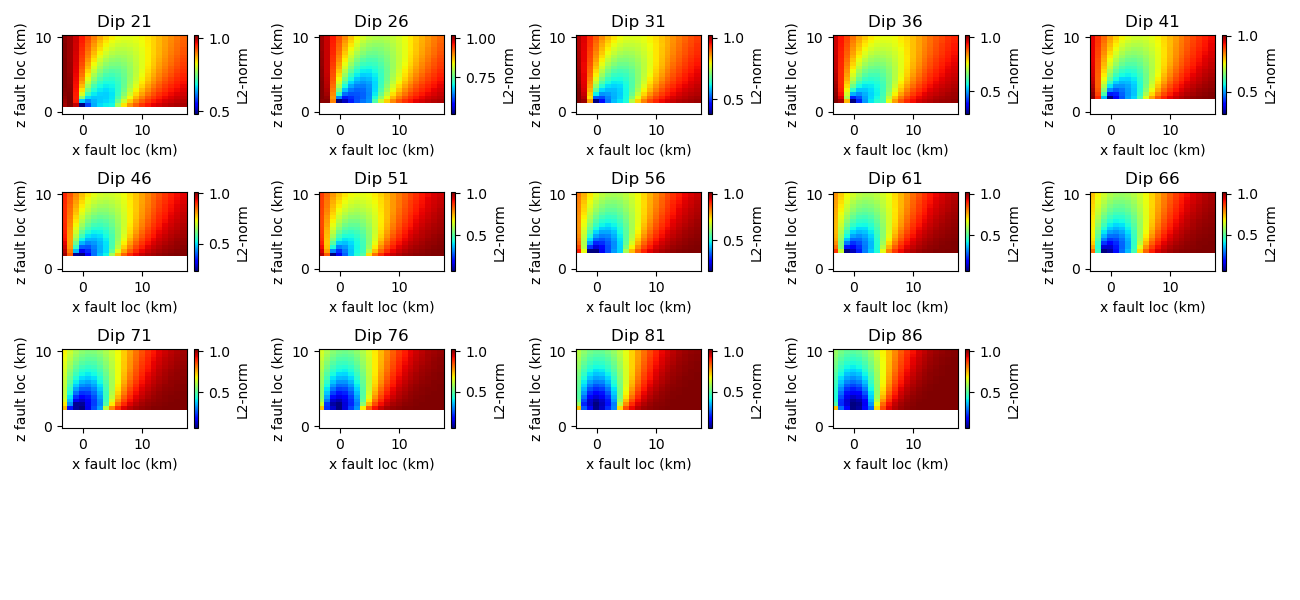

Best-fit dip: 		81
Best-fit x location: 	0
Best-fit z location: 	3000


In [23]:
# plot all slices of the 3D L2_norms array to see if there are global minima I can see visually 
plt.figure(figsize=(13,6),tight_layout=True)
sbplt = 1
for di in range(len(dips)):
    plt.subplot(4,5,sbplt)
    plt.pcolor(x_fault_locs/1000,z_fault_locs/1000,L2_norms_LS[di],cmap='jet')
    plt.xlabel('x fault loc (km)')
    plt.ylabel('z fault loc (km)')
    plt.title('Dip '+str(dips[di]))
    plt.colorbar(label='L2-norm')
    sbplt = sbplt+1
plt.show()

best_dip, best_xloc, best_zloc = find_L2_norm_minimum(L2_norms_LS,dips,x_fault_locs,z_fault_locs)

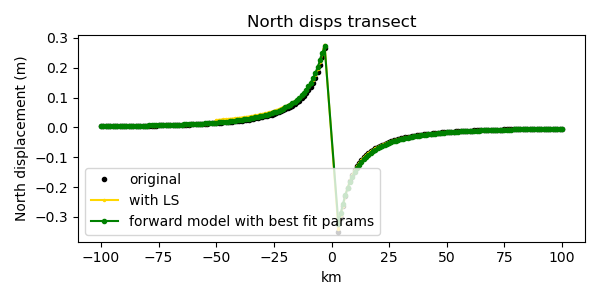

In [24]:
# Now input these best-fit values into the Okada model so I can compare what the forward-modelled version looks like.
dat_predicted_LS, m_solved_LS, temp_L2_norm_LS = L2norm_for_fault_config(x_vals, dat_2, best_dip, best_xloc, best_zloc)

plt.figure(figsize=(6,3),tight_layout=True)
plt.plot(x_vals/1000,transect_north,'k.',label='original')
plt.plot(x_vals/1000,transect_north_LS,color='gold',marker='.',ms=3,label='with LS')
plt.plot(x_vals/1000,dat_predicted_LS,color='green',marker='.',label='forward model with best fit params')
plt.xlabel('km')
plt.ylabel('North displacement (m)')
plt.title('North disps transect')
plt.legend(loc='lower left')
plt.show()

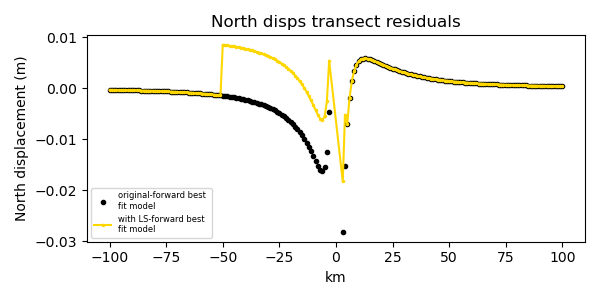

In [25]:
plt.figure(figsize=(6,3),tight_layout=True)
plt.plot(x_vals/1000,transect_north-dat_predicted_LS,'k.',label='original-forward best \nfit model')
plt.plot(x_vals/1000,transect_north_LS-dat_predicted_LS,color='gold',marker='.',ms=3,label='with LS-forward best \nfit model')
plt.xlabel('km')
plt.ylabel('North displacement (m)')
plt.title('North disps transect residuals')
plt.legend(loc='lower left',fontsize=6)
plt.show()

In [26]:
# now use the patch_geometry code to actually plot the "true" fault and the solved-for fault locations. They will be pretty different. 

# fault structure object (list) for inputting into geometry function to plot it in 3D.
faultstruct = [
    {   # This one is the input fault
        'L': length,                # Length of the fault (along-strike)
        'W': width,                 # Width of the fault (down-dip)
        'strike': strike,              # Strike angle in degrees
        'dip': delta,                  # Dip angle in degrees
        'zt': d-width/2,                  # Top depth of the fault
        'vertices': np.array([
            [0.0, 0.0],             # x coordinates of fault endpoints
            [0.0, 0.0]              # y coordinates of fault endpoints
        ])                          # I think the important part is that the average X is the fault top line midpoint X value, same for Y 
    },
    {   # This is the best-fit fault to the fault slip + LS signal 
        'L': length,
        'W': width,
        'strike': strike,
        'dip': best_dip,
        'zt': best_zloc-width/2,
        'vertices': np.array([
            [best_xloc, best_xloc], # x coords that need to average to the x fault center locatin 
            [0.0, 0.0]
        ])
    }
    ]


In [27]:
# now run it through the patch_geometry code
targetLp = 1   # total subdivisions along the length (L)
Wp = 1         # number of subdivisions along width (W)
# how many faults per break, put this in brackets always (even if just one segment),  
faultnp=[1,1]     # 2 faults, no breaks would be [1,1]
patchstruct, totLp, Wp_output, Lps = ver2patchconnect(faultstruct,targetLp,Wp,faultnp)

# what do the contents look like? 
print(patchstruct[0]['xfault'])
print(patchstruct[0]['yfault'])
print(patchstruct[0]['zfault'])

[   0.            0.         1627.84077229 1627.84077229    0.        ]
[ 50000. -50000. -50000.  50000.  50000.]
[   0.          0.       4727.592878 4727.592878    0.      ]


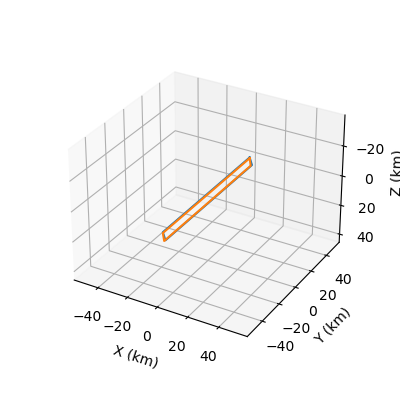

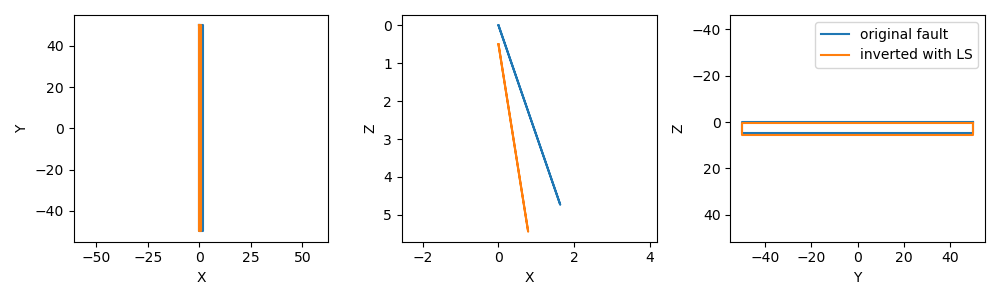

In [28]:
# 3D plot of fault patch corners 
ax = plt.figure(figsize=(4,4)).add_subplot(projection='3d')
# 2D plots in each XY, XZ, and YZ projections 
fig, ax1 = plt.subplots(1,3,figsize=(10,3),tight_layout=True)

for i in range(len(patchstruct)): # range(len(patchstruct))
    # add the patch to the 3D plot 
    ax.plot(patchstruct[i]['xfault']/1000,patchstruct[i]['yfault']/1000,zs=patchstruct[i]['zfault']/1000)
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)') # flipping this axis didn't do anything, with 2 methods. Just have to manually rotate it to show + values as down/depth 
    
    # maybe I can set an elevation, azimuth, and roll for the initial display ???
    
    ax.axis('equal')
    # add the patch to the 2D plots 
    ax1[0].plot(patchstruct[i]['xfault']/1000,patchstruct[i]['yfault']/1000,linestyle='-')
    ax1[0].set_xlabel('X'); ax1[0].set_ylabel('Y'); ax1[0].axis('equal')
    ax1[1].plot(patchstruct[i]['xfault']/1000,patchstruct[i]['zfault']/1000,linestyle='-')
    ax1[1].set_xlabel('X'); ax1[1].set_ylabel('Z'); ax1[1].axis('equal')
    ax1[2].plot(patchstruct[i]['yfault']/1000,patchstruct[i]['zfault']/1000,linestyle='-')
    ax1[2].set_xlabel('Y'); ax1[2].set_ylabel('Z'); ax1[2].axis('equal')

ax1[2].legend(['original fault','inverted with LS'])
ax.invert_zaxis()
ax1[1].invert_yaxis()
ax1[2].invert_yaxis()

In [29]:
# Now vary the dip, fit a best x location and z location, then plot the forward modeled slip transect of that fault configuration 
# find the minimum L2 norm value for each "slice" of the L2_norms cube, then forward model that fault and save the disp transect 

# initialize an array to hold transects of all best fit transects to each dip 
best_fit_transects_to_dips = np.ndarray((len(dips),len(x_vals)),dtype='float')

# for each dip, find the minimum L2 norm value 
for i in range(len(dips)): #len(dips)
    best_loc_coords_flat = np.nanargmin(L2_norms_LS[i])
    best_loc_coords = np.unravel_index(best_loc_coords_flat,np.shape(L2_norms_LS[i]))
    # find the actual values of the best fit xloc and zloc from the unravelled indices
    temp_best_fit_zloc = z_fault_locs[best_loc_coords[0]]
    temp_best_fit_xloc = z_fault_locs[best_loc_coords[1]]
    # now forward model them into a transect 
    temp_dat_predicted_LS, temp_m, temp_L2_norm_LS = L2norm_for_fault_config(x_vals, dat_2, dips[i], temp_best_fit_xloc, temp_best_fit_zloc)
    # save the transect data so I can plot it 
    best_fit_transects_to_dips[i] = temp_dat_predicted_LS

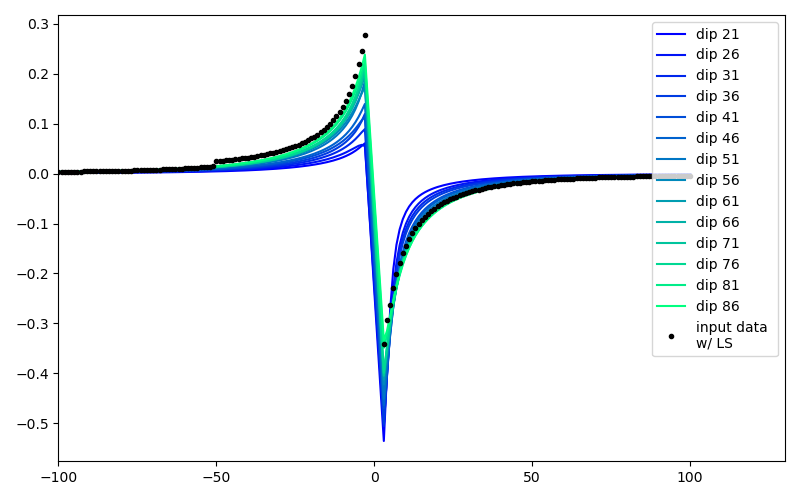

In [30]:
import matplotlib.cm as cm
cmap = cm.get_cmap('winter')

plt.figure(figsize=(8,5),tight_layout=True)
for i in range(len(dips)):
    color_index = i/(len(dips)-1)
    color = cmap(color_index)
    temp_label = 'dip '+str(dips[i])
    plt.plot(x_vals/1000,best_fit_transects_to_dips[i],color=color,label=temp_label)
plt.plot(x_vals/1000,transect_north_LS,'k.',label='input data \nw/ LS')
plt.legend(loc='upper right')
plt.xlim(-100,130)
plt.show()